In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
class SIR:
    def __init__(self, init_values, times, parameters, is_first_phase=False):
        self.init_values = np.array(init_values)
        self.times = times
        self.parameters = parameters
        self.is_first_phase = is_first_phase

    def model(self, init_values, is_first_phase=False):

        lambda_ = self.parameters['lambda']
        gamma1 = self.parameters['gamma1']
        gamma2 = self.parameters['gamma2']
        alpha = self.parameters['alpha']
        sigma = self.parameters['sigma']
        mu = self.parameters['mu']

        S, I, R, H, V, D = init_values
        if is_first_phase:
            dI = lambda_ * S - alpha * I - gamma1 * I
            dS = -lambda_ * S + sigma * R
            dV = 0
        else:
            p = self.parameters['p']
            q = self.parameters['q']
            dS = - lambda_ * S - p * S + sigma * R
            dI = (1 - q) * lambda_ * V + lambda_ * \
                S - alpha * I - gamma1 * I
            dV = -(1 - q) * lambda_ * V + p * S
        dR = gamma1 * I + gamma2 * H - sigma * R
        dH = alpha * I - mu * H - gamma2 * H
        dD = H * mu

        differential_values = np.array(
            [dS, dI, dR, dH, dV, dD])

        return differential_values

    def run(self, model, times, is_first_phase):
        output = [self.init_values]

        for iter in times:
            differential_values = model(
                init_values=output[-1], is_first_phase=is_first_phase)
            last_values = output[-1] + differential_values
            output.append(last_values)

        return output

    def solve(self):

        output = self.run(
            self.model,
            self.times[1:],
            self.is_first_phase
        )
        table = pd.DataFrame(
            output,
            columns=['S', 'I', 'R', 'H', 'V', 'D']
        )
        table['times'] = self.times
        table.set_index(['times'], inplace=True)
        return table

    def plot(self):
        output = self.solve()
        plt.plot(
            output,
        )
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


In [3]:
init_values = [10116999, 1, 0, 0, 0, 0]
times = range(1, 313)
parameters = {
    'lambda': 0.03375,
    'alpha': 0.0066603049,
    'gamma1': 0.0714285714,
    'gamma2': 0.0476190476,
    'mu': 0.0003456704,
    'sigma': 0.0111111111,
    'p': 0.0000113893,
    'q': 0.79
}

demo = SIR(init_values, times, parameters, is_first_phase=True)
data = demo.solve()
data


,S,I,R,H,V,D
times,,,,,,
1,1.011700e+07,1.000000e+00,0.000000e+00,0.000000,0.0,0.000000
2,9.775550e+06,3.414496e+05,7.142857e-02,0.006660,0.0,0.000000
3,9.445625e+06,6.447110e+05,2.438933e+04,2274.165039,0.0,0.000002
4,9.127107e+06,9.131561e+05,7.027742e+04,6459.057464,0.0,0.786114
5,8.819848e+06,1.149889e+06,1.350296e+05,12231.148910,0.0,3.018819
...,...,...,...,...,...,...
308,2.230131e+06,9.639178e+05,6.773107e+06,133861.306614,0.0,15983.505816
309,2.230120e+06,9.639134e+05,6.773076e+06,133860.673045,0.0,16029.777707
310,2.230110e+06,9.639091e+05,6.773045e+06,133860.040888,0.0,16076.049380


In [4]:
total_init_values = {
    '00_17': [10116999, 1, 0, 0, 0, 0],
    '18_64': [36138999, 1, 0, 0, 0, 0],
    '65_84': [9315999, 1, 0, 0, 0, 0],
    '85_': [1456999, 1, 0, 0, 0, 0]
}

total_times = {
    'phase1': np.arange(np.datetime64('2020-03-01'), np.datetime64('2020-12-08')),
    'phase2': np.arange(np.datetime64('2020-12-07'), np.datetime64('2021-05-17')),
    'phase3': np.arange(np.datetime64('2021-05-16'), np.datetime64('2021-11-27')),
    'phase4': np.arange(np.datetime64('2021-11-26'), np.datetime64('2022-08-19'))
}

q_map = {
    'phase2': 0.79,
    'phase3': 0.67,
    'phase4': 0.62
}

vars = pd.read_csv("./new_vars_calc.csv", index_col=['phase', 'age_group', 'var_name'])
adjusted_p = pd.read_csv("./adjusted_p.csv", index_col=['coverage'])

def get_parameters(phase, age_group, coverage = '-1', vars=vars['mean'], adjusted_p=adjusted_p):
    parameters = {
        'gamma1': 0.0714285714,
        'gamma2': 0.0476190476,
        'sigma': 0.0111111111,
    }
    
    parameters['lambda'] = vars.loc[phase, age_group, 'lambda'] 
    parameters['mu'] = vars.loc[phase, age_group, 'mu']
    parameters['alpha'] = vars.loc[phase, age_group, 'alpha']

    if phase != 'phase1':
        if coverage in adjusted_p.index:
            adjusted_p.loc[coverage]["p%s" % age_group]
        else:
            parameters['p'] = vars.loc[phase, age_group, 'p']
        parameters['q'] = q_map[phase]

    return parameters



In [5]:
phases = [
    'phase1',
    'phase2' # ,
    # 'phase3',
    # 'phase4'
]

age_groups = [
    '00_17',
    '18_64',
    '65_84',
    '85_'
]

coverages = ['unadjusted'] + adjusted_p.index.to_list()

total_output = pd.DataFrame()
for coverage in coverages:
    coverage_output = pd.DataFrame()
    for age_group in age_groups:
        age_output = pd.DataFrame()
        init_values = total_init_values[age_group]
        for phase in phases:
            is_first_phase = phase == 'phase1'
            parameters = get_parameters(phase, age_group)
            times = total_times[phase]
            sir_model = SIR(
                init_values=init_values,
                times=times,
                parameters=parameters,
                is_first_phase=is_first_phase
            )
            output_tmp =  sir_model.solve() if is_first_phase else sir_model.solve().iloc[1:]
            init_values = output_tmp.iloc[-1].to_list()
            age_output = pd.concat([age_output, output_tmp], axis=0)
        age_output['age_group'] = age_group
        coverage_output = pd.concat([coverage_output, age_output])

    coverage_output['coverage'] = coverage
    total_output = pd.concat([total_output, coverage_output])

total_output['times'] = total_output.index
total_output.set_index(['coverage', 'age_group', 'times'], inplace=True)

total_output.to_csv("./coverage_sir_output.csv")


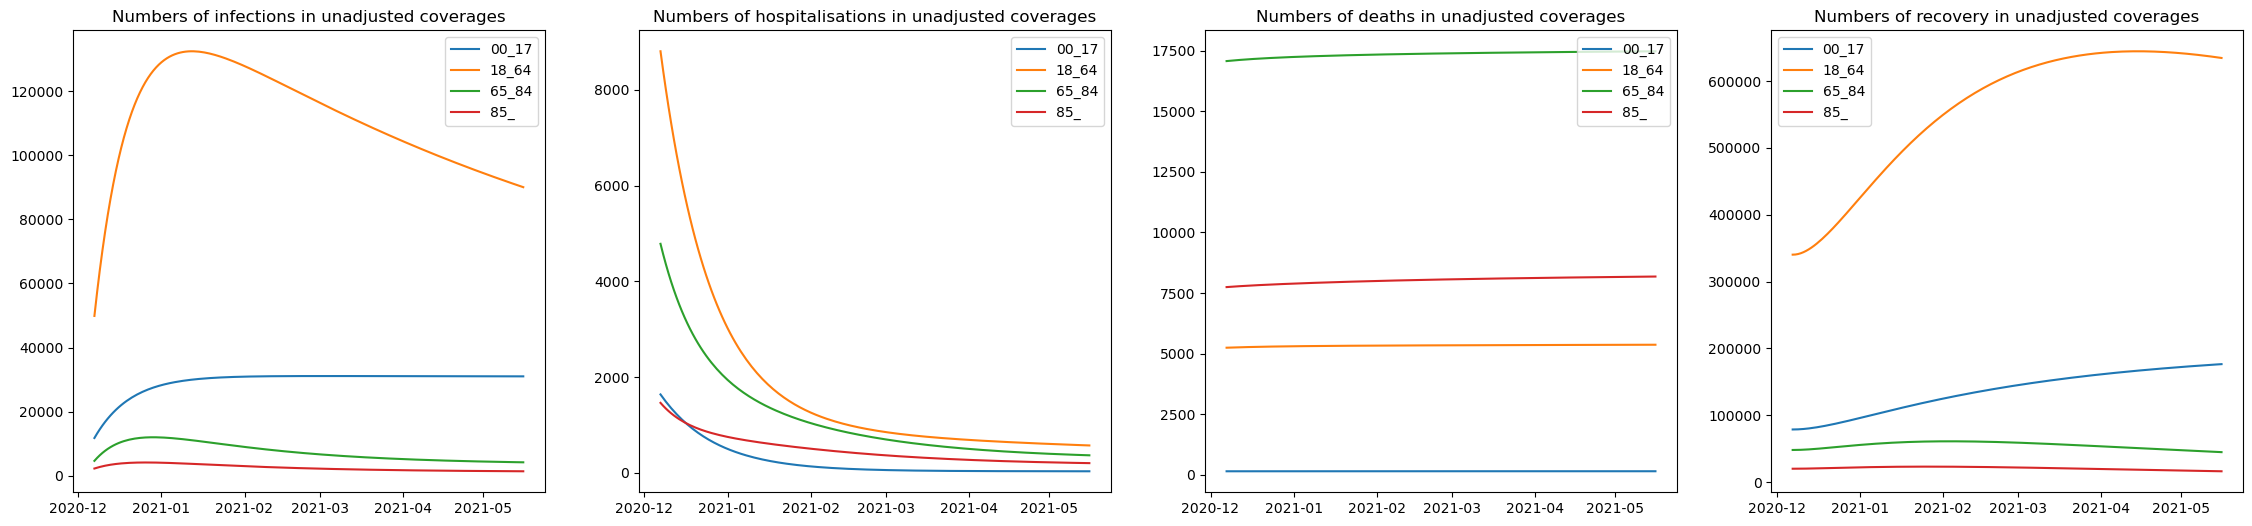

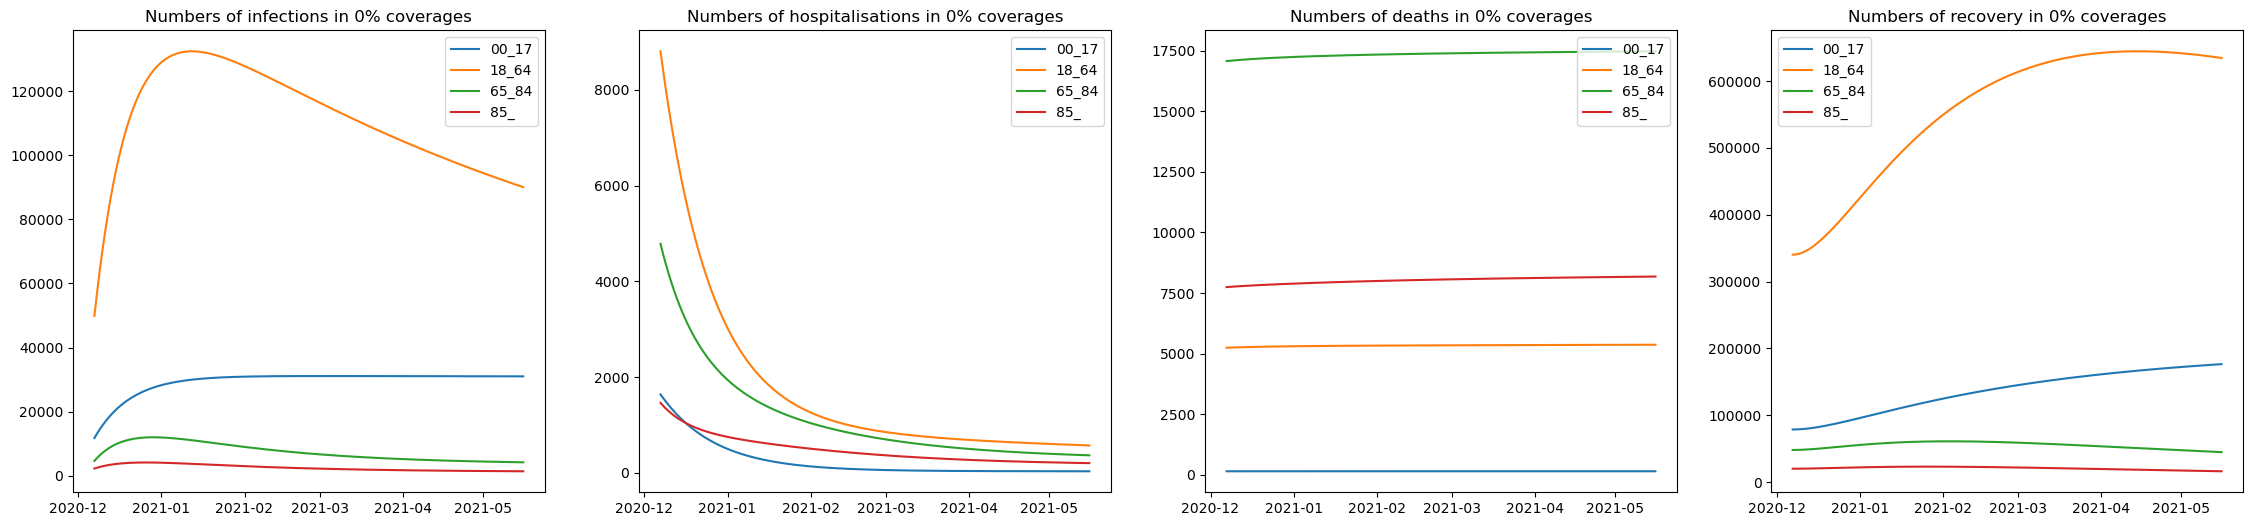

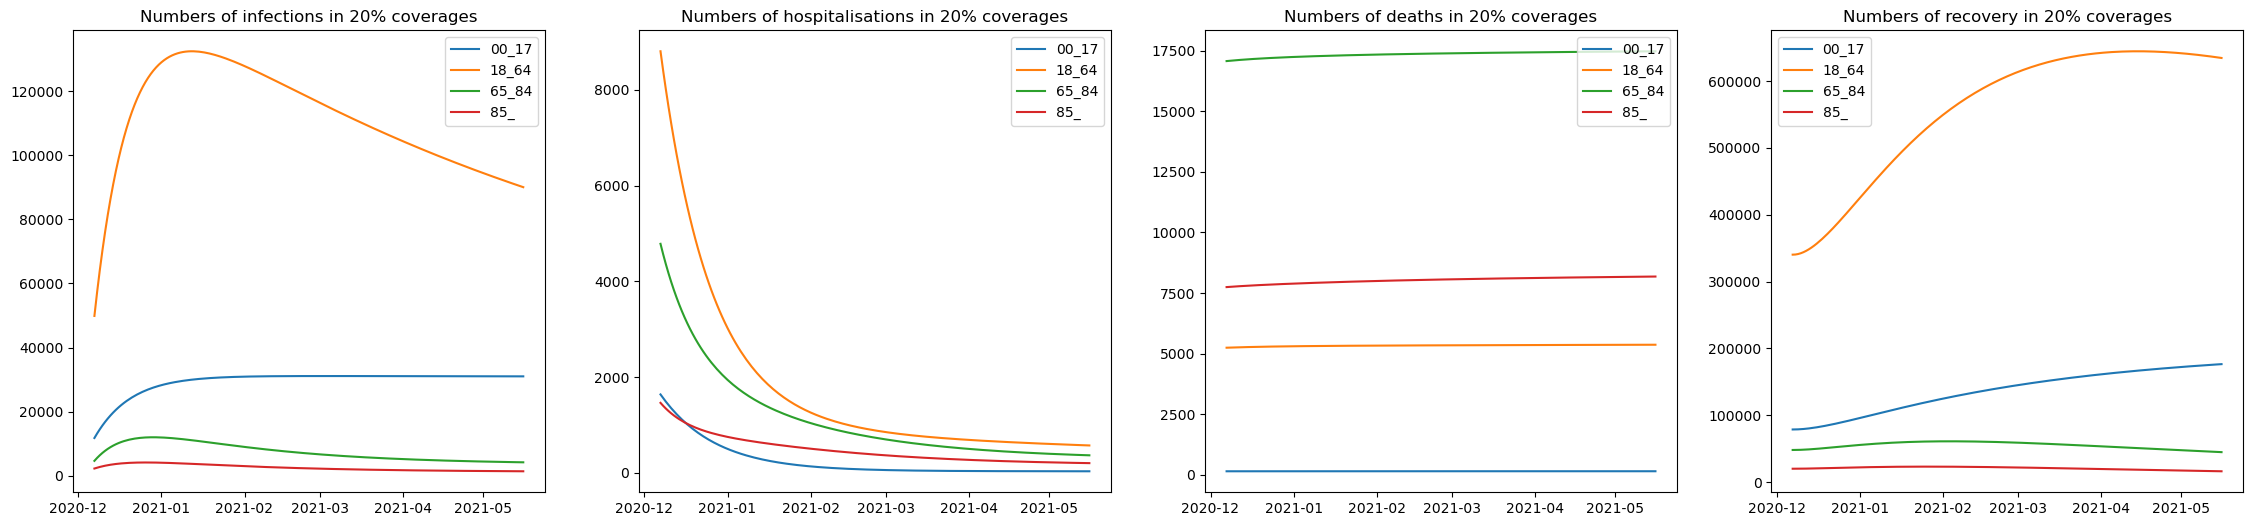

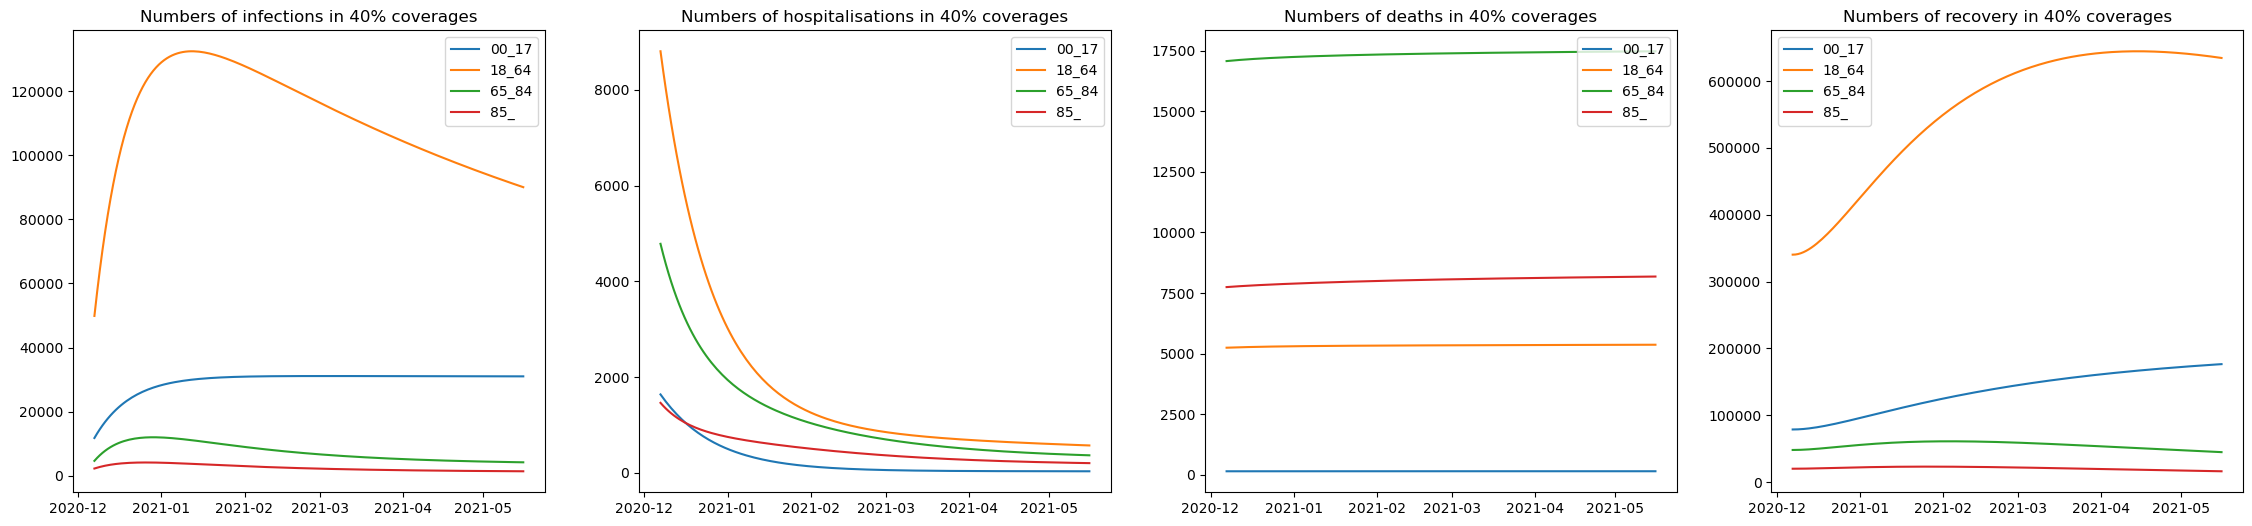

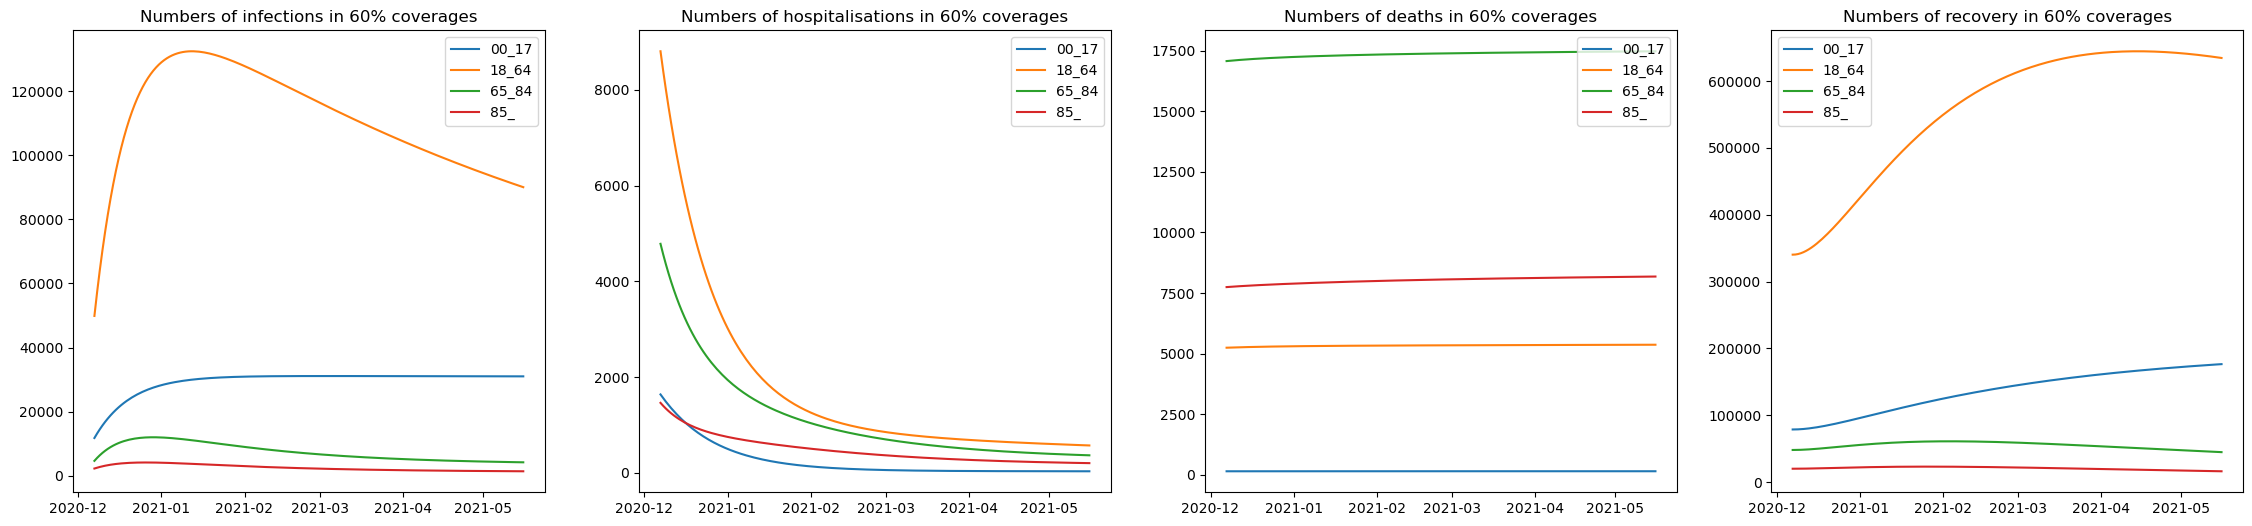

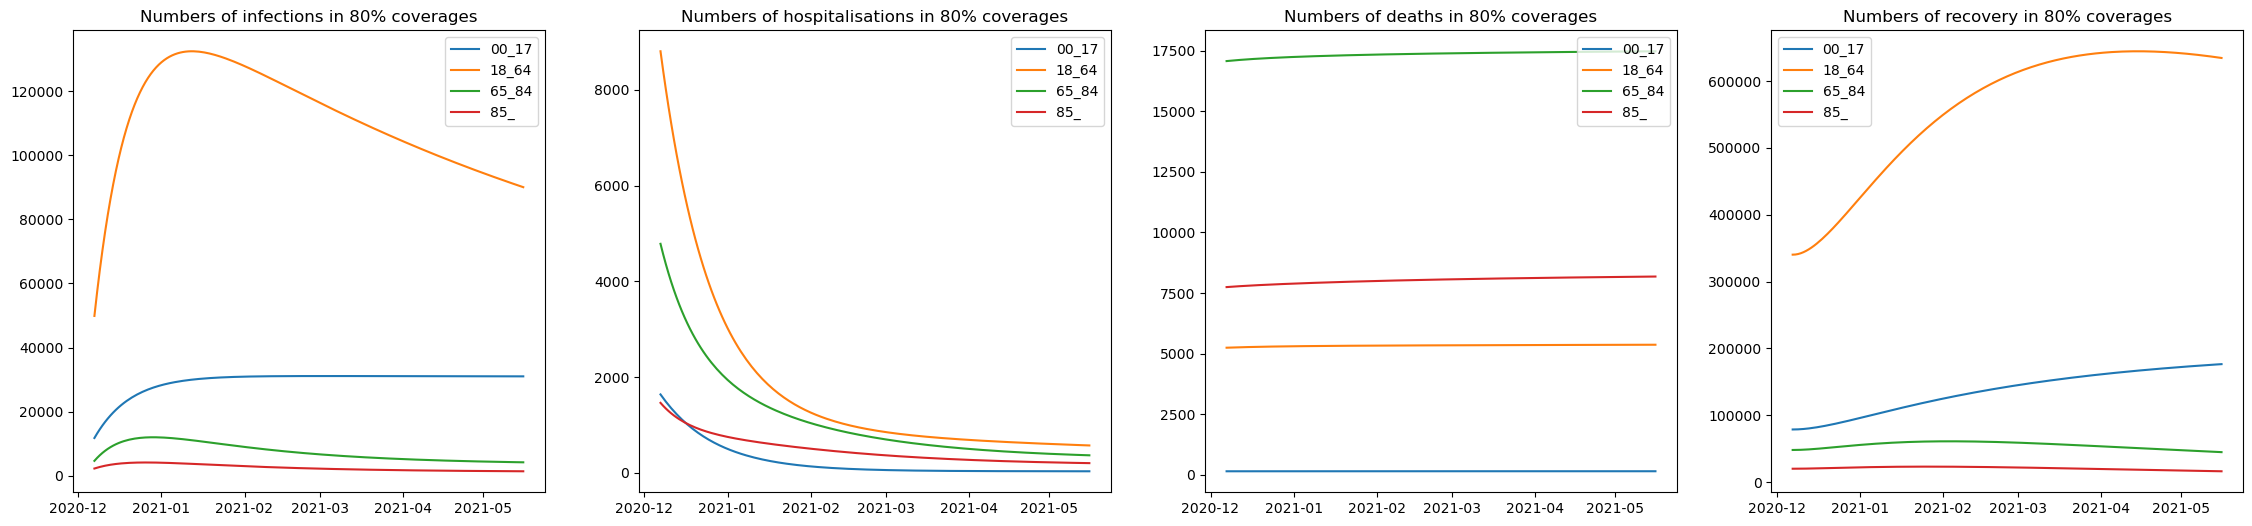

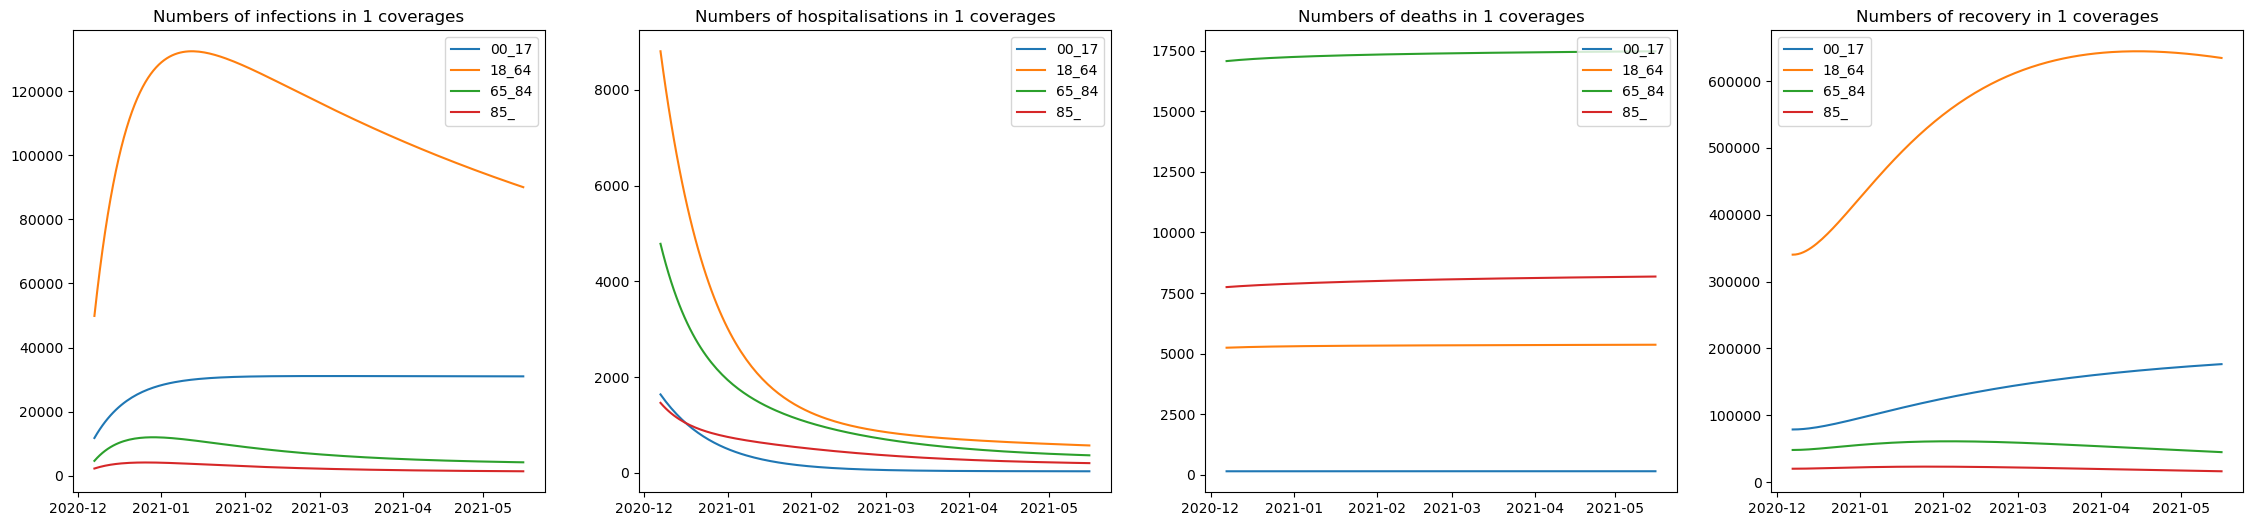

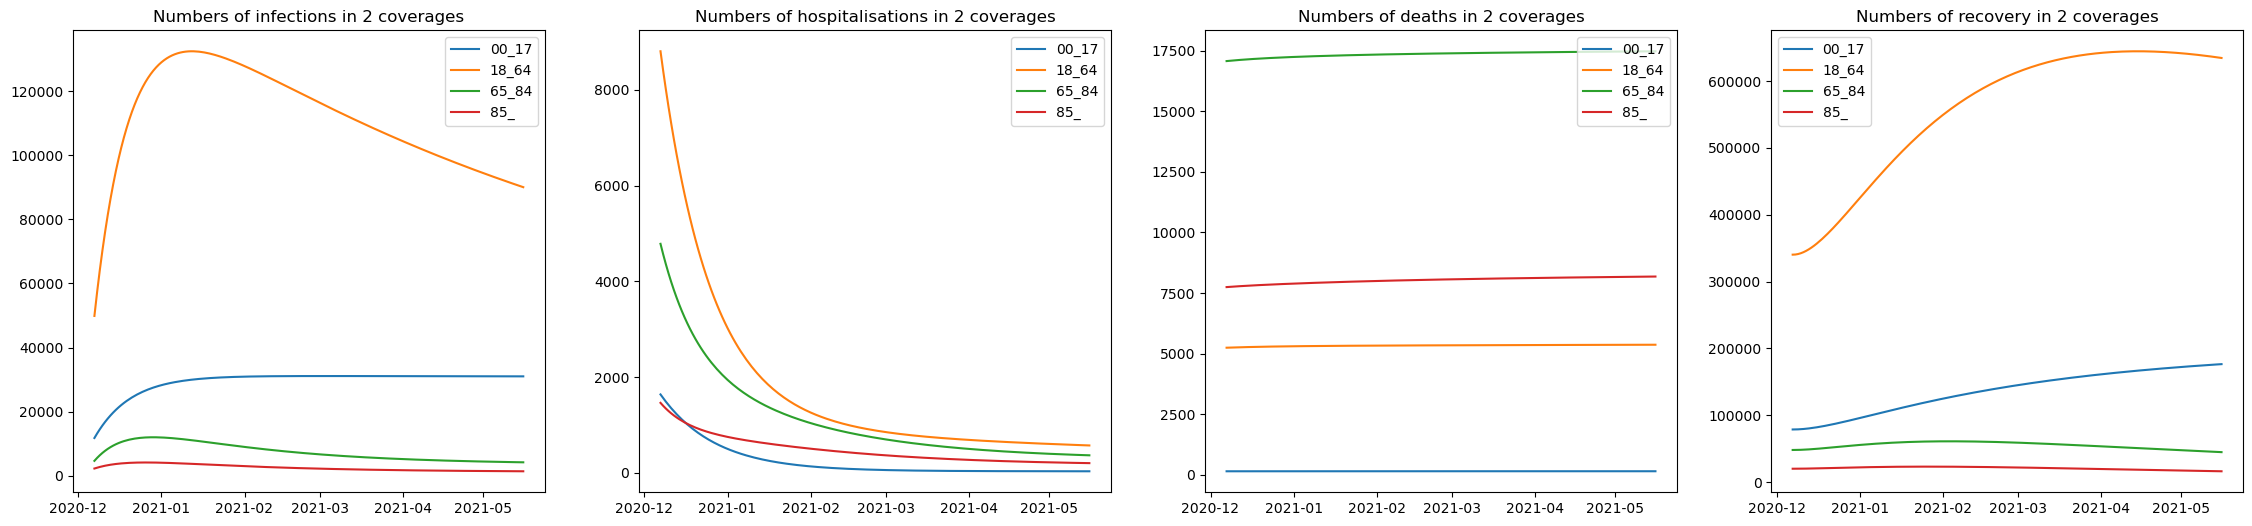

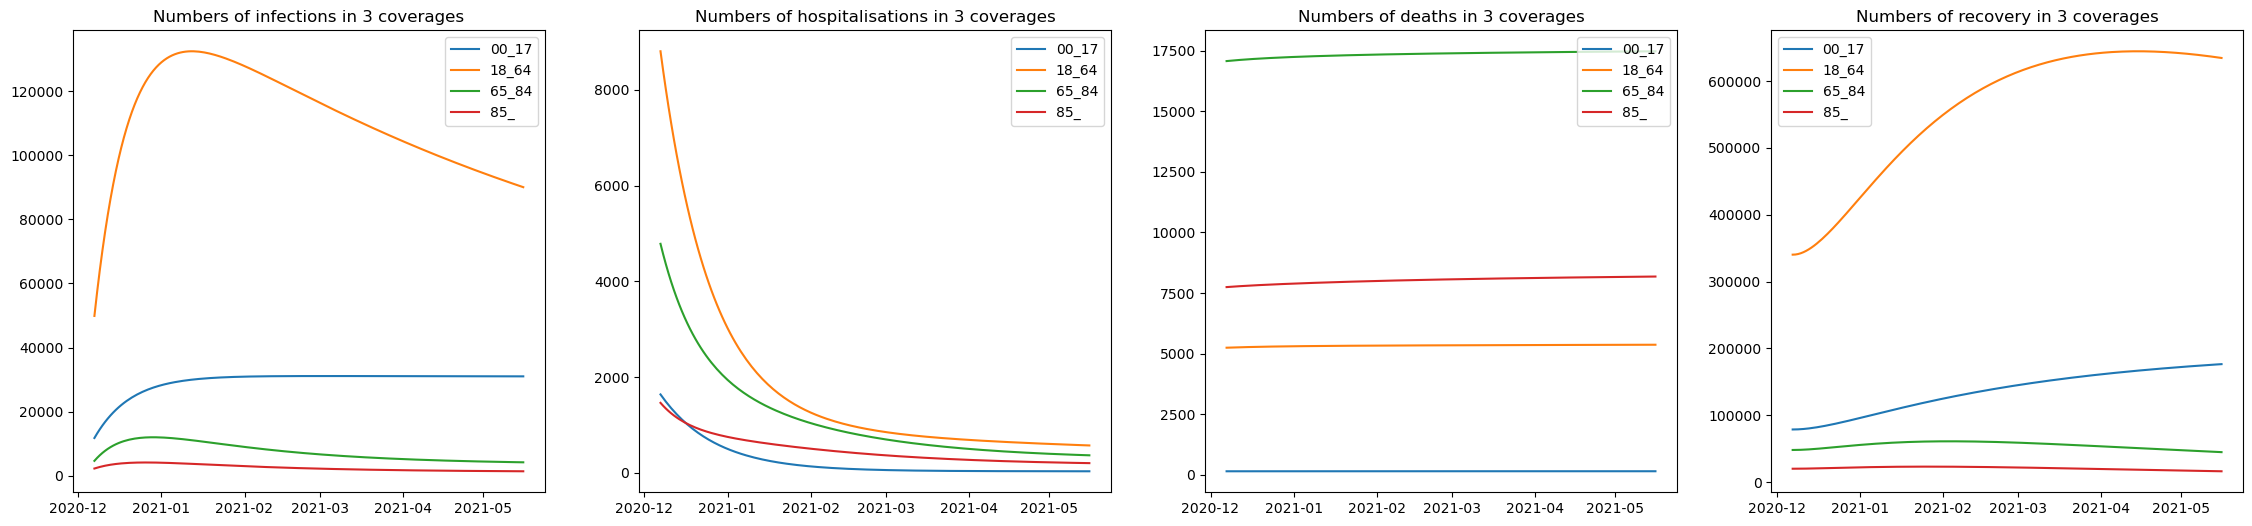

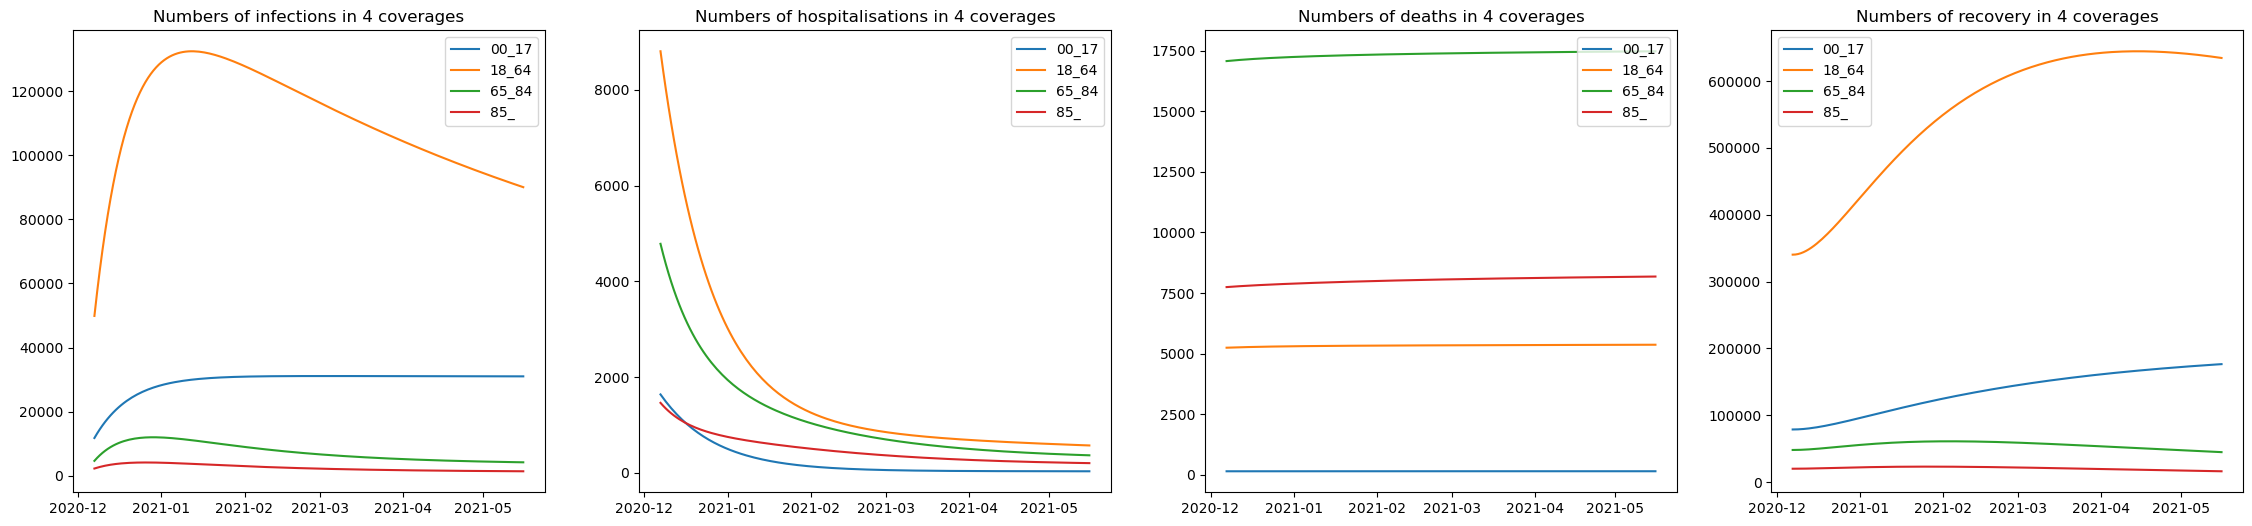

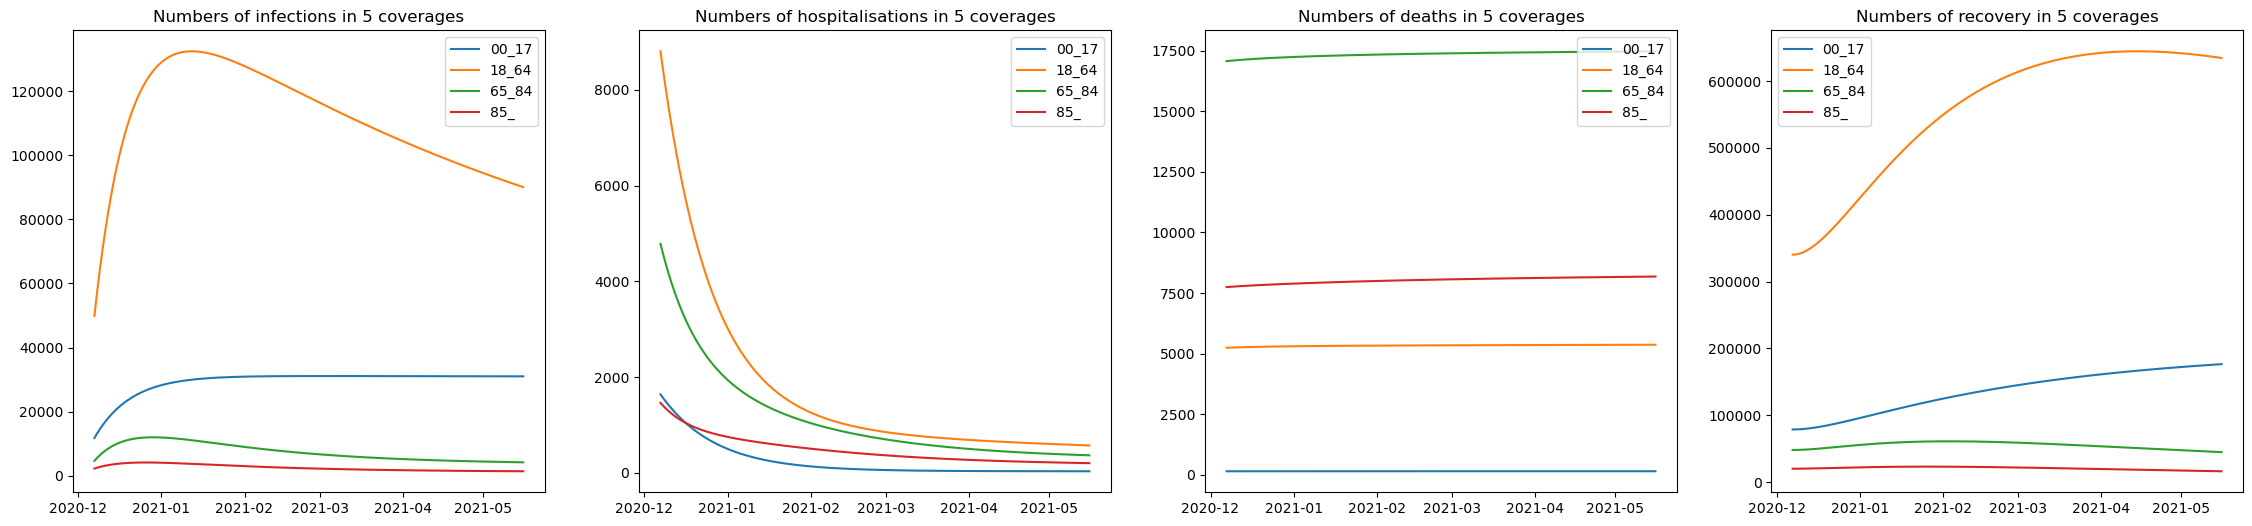

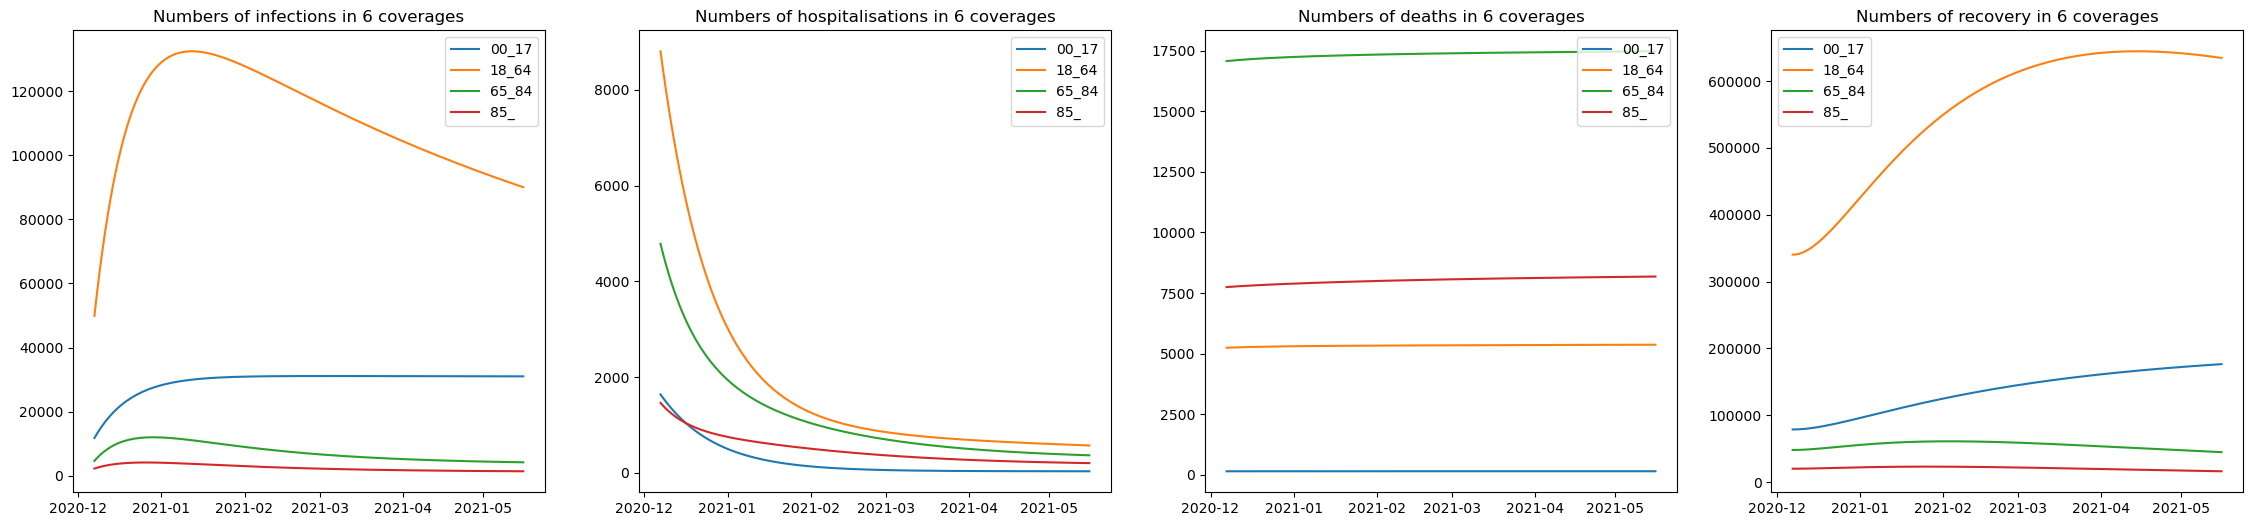

In [6]:
plt.rcParams['figure.figsize'] = (28,6)

def sir_plot(data, age_groups = age_groups):
    # I H D R
    pass

    coverages = ['unadjusted', '0%', '20%', '40%', '60%', '80%', '1', '2', '3', '4', '5', '6']
    age_groups = age_groups = [
        '00_17',
        '18_64',
        '65_84',
        '85_'
    ]
    index = ['I', 'H', 'D', 'R']
    
    index_map = {
        'I': "infections",
        'H': "hospitalisations",
        'D': "deaths",
        'R': "recovery"
    }
    
    for coverage in coverages:
        fig, ax = plt.subplots(nrows=1, ncols=4)
        for i in range(len(index)):
            for age_group in age_groups:
                plot_data = data.loc[coverage, age_group][index[i]]
                plot_data = plot_data[total_times['phase2']]
                ax[i].plot(plot_data, label=age_group)
            ax[i].set_title("Numbers of %s in %s coverages" % (index_map[index[i]], coverage))
            ax[i].legend()
            # print(ax)
        # fig.show()

sir_plot(total_output)